<img src='https://www.icos-cp.eu/sites/default/files/2017-11/ICOS_CP_logo.png' width=400 align=right>

# ICOS Carbon Portal Python Library
## Example: Reading an ObsPack collection

We will showcase two different methods / ways of reading the OpsPack data with python

1. Download the file, unpack und load the data
2. Access the collection usgin our python library<br>
   load directly into memory, no need to download. This works external as well (on your computer)<br>
   or after you login to this Jupyter Service from the ICOS Carbon Portal.

## Documentation
Full documentation for the ICOS python library is availalbe on the [project page](https://icos-carbon-portal.github.io/pylib/), how to install and wheel on [pypi.org](https://pypi.org/project/icoscp/), source is available on [github](https://github.com/ICOS-Carbon-Portal/pylib).

## Introduction
The goal of this notebook is to show you the ease of use of Jupyter Notebooks and to familiarize you with ObsPack collections and the files stored within these ObsPacks. This notebook will first show how to read in a local NetCDF file that originates from an ObsPack collection (for a specific station, tracer, and measurement height), and how to subset and plot the measurements within the file. 

In a next step, we will show how to read in an ObsPack file using the ICOS Python Library (i.e. the *icoscp* Python package). This is an API that allows you to read in all data stored on the ICOS Carbon Portal without having to download the data, providing an efficient way to read in and process atmospheric measurements and model results in memory.

## Import python packages
Note: We chose to make use of the xarray package instead of the netCDF4 package, as the former is more versatile and better supported.

In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt

# Make the matplotlib figures interactive with zoom, pan, move, save figures etc.. but the figures are not that nice anymore
# %matplotlib widget

from pylab import plot, boxplot, setp
import seaborn as sns
color_pal = sns.color_palette()
import zipfile
import datetime
import numpy as np
import math
from tqdm.notebook import tqdm
import pandas as pd

# ICOS Library
from icoscp.collection import collection
from icoscp.cpb.dobj import Dobj

/opt/conda/lib/python3.10/site-packages/icoscp/cpauth/exceptions.py:42: FutureWarning: 
The ICOS Carbon Portal python library (>=0.1.19) requires user authentication for external users.
Only credentials used for password sign-in at https://cpauth.icos-cp.eu/ can be used for authentication.
Internal users (ICOS CP Jupyter Notebook services) are exempt.
For the authentication module documentation, follow this link: https://icos-carbon-portal.github.io/pylib/modules/#authentication
To suppress this message we refer to the documentation here: https://icos-carbon-portal.github.io/pylib/faq/#how-do-i-suppress-warnings
  warnings.warn(warning, category=FutureWarning)


## Define functions, used later in the notebook

### Label
return a 'label' containing station information, location and sampling height

In [2]:
def label(dobj):
    '''
    A function to extract information from a digital object.
    A digitial Object, the representation of a data set returned from the icoscp library
    (do) includes a very rich set of meta data.
    For convenience we extract some of the information to display.
      
    Returns a string with the station id, name, and sampling height.
    This can be for example added to the data frame for grouping, or used as series title
    '''
    info ={}
    # sampling height
    info['sh'] = dobj.meta['specificInfo']['acquisition']['samplingHeight']
    # station id & name
    info['id'] = dobj.meta['specificInfo']['acquisition']['station']['id']
    info['name'] = dobj.meta['specificInfo']['acquisition']['station']['org']['name']
    
    return f"{info['id']} {info['name']} {info['sh']} m"

### Sampling Height
Return the sampling height (intake height) for the dataset. By default a float is returned, expressing the sampling height in meters above ground.

In [3]:
def sampling_height(dobj):
    return dobj.meta['specificInfo']['acquisition']['samplingHeight']

### Data Features
To work with the dataset we create a add feature function to add some conveniences:
- add features so we can group by month or year
- change the index to datetime, makes it much easier to plot time series data
- add a column with 'ppm' values

In [4]:
def data_feature(dobj):
    '''
    a data wrangling function to return the data as pandas dataframe
    with index set to the timestamp for easy plotting
    and add some features for data analysis.
    

    Parameters
    ----------
    dobj : Dobj from the icoscp library. The re
    
    Returns
    -------
    Pandas Dataframe    
    '''
    df = dobj.data
    # set index to datetime
    df.index = pd.to_datetime(df.time)
    
    # add colums to aggregate on
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    
    # multiply the *value* with 10^6 to disply 'ppm'
    df['ppm'] = df.value * 1e6
    
    # add sampling height 
    df['samplingheight'] = sampling_height(dobj)
    return df    

### Rolling z-score
Z-Score will show how many standard deviations the value is away from the the mean.<br>
For seasonal data, it seems a good choice to have z-score calculated from a rolling mean/std to find and display outliers<br>
The following function is adapted from [https://stackoverflow.com/](https://stackoverflow.com/questions/47164950/compute-rolling-z-score-in-pandas-dataframe)
, apparently much faster than the built in function from pandas.
    

In [5]:
def zscore(data, window=720):
    '''
    Calculate the z-score.. how much standard deviation is the data point away from the mean
    We will use this to plot outliers. For this example we now that we have hourly
    measurements; we have opted for a default window size of a month (24*30=720)

    Parameters
    ----------
    data : Pandas serires
    
    Returns
    -------
    Pandas Series
    '''
    r = data.rolling(window=window)    
    m = r.mean().shift(1)
    #m = r.mean()
    s = r.std(ddof=0).shift(1)
    z = (data-m)/s
    return z

# 1. Download the file, unpack und load the data

### How to read in a local NetCDF file coming from an ObsPack collection

#### Read in the data
The following NetCDF file will be used as an example: co2_cbw_tower-insitu_445_allvalid-207magl.nc. This file contains CO2 mole fraction observations from the Cabauw station at 207 meters a.g.l.
Files like this are available, if you download the collection from the data portal ( [https://www.icos-cp.eu/data-products/CEC4-CAGK](https://www.icos-cp.eu/data-products/CEC4-CAGK) ). Then you can work offline on your own computer. For this demo, we have made one of the files available in the current 'data' folder

In [ ]:
# Give the path of local nc file
path = './data/co2_cbw_tower-insitu_445_allvalid-207magl.nc'

# Open the local nc file
cbw_data = xr.open_dataset(path)

# Explore some of the characteristics of the data
print("These are the dimensions of the data set:")
print(str(list(cbw_data.coords)) + "\n")

print("These are the variables of the data set:")
print(str(list(cbw_data.keys())))

### Explore the ObsPack entry

In [ ]:
cbw_data

### Subset the data

In [ ]:
# Select a time period of interest. Here: JJA 2018
cbw_subset = cbw_data.sel(time=slice('2018-06-01', '2018-09-01'))

### Creating a CO2 mixing ratio timeseries

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols = 1, figsize=(12,4))
ax.grid(zorder=0)
plt.plot(cbw_subset.time, cbw_subset.value * 1e6, '-', zorder=2, label = 'CO2 dry mole fraction')
ax.set_title(cbw_subset.site_name)
ax.set_ylabel(str(cbw_data.value.standard_name) + ' [ppm]')
ax.set_xlabel('time')
ax.set_xlim([min(cbw_subset.time),max(cbw_subset.time)])
ax.set_ylim([380,460])
plt.xticks(rotation = 45)
plt.legend()

# if you want to save the image... uncomment the following line
# plt.savefig('co2_cabauw.png')

### Assigning a new variable to the ObsPack using xarray

In [ ]:
## Create a synthetic mole fraction observation variable with a randomized uncertainty (noise)
noise = np.random.normal(2.1e-6, 1.5e-6, len(cbw_subset.value))
model = cbw_subset.value + noise

## Insert the newly created variable into the ObsPack
## (Use the xr.assign() function)
cbw_subset = cbw_subset.assign(model=model)
cbw_subset

### Adding the synthetic simulation results to the timeseries plot

In [ ]:
## Make a timeseries plot similar to the one before, but now adding the synthetic model results
fig, ax = plt.subplots(nrows=1, ncols = 1, figsize=(10,4))
ax.grid(zorder=0)
plt.plot(cbw_subset.time, cbw_subset.value * 1e6, '-', zorder=2, label = 'Observed CO2 dry mole fraction')
plt.plot(cbw_subset.time, cbw_subset.model * 1e6, '-', zorder=2, label = 'Modelled CO2 dry mole fraction')
ax.set_title(cbw_subset.site_name)
ax.set_ylabel(str(cbw_data.value.standard_name) + ' [ppm]')
ax.set_xlabel('time')
ax.set_xlim([min(cbw_subset.time),max(cbw_subset.time)])
ax.set_ylim([380,460])
plt.xticks(rotation = 0)
plt.legend()

### Plotting a timeseries of the residuals

In [ ]:
## Make a residual timeseries plot
fig, ax = plt.subplots(nrows=1, ncols = 1, figsize=(12,4))
ax.grid(zorder=0)
plt.plot(cbw_subset.time, (cbw_subset.model - cbw_subset.value) * 1e6, '-', c = 'r', zorder=2, label = 'Model error / residual CO2 mole fraction')
ax.set_title(cbw_subset.site_name)
ax.set_ylabel(str(cbw_data.value.standard_name) + '\n residual [ppm]')
ax.set_xlabel('time')
ax.set_xlim([min(cbw_subset.time),max(cbw_subset.time)])
ax.set_ylim([-7.5,7.5])
plt.xticks(rotation = 10, fontsize=8)
plt.legend()

In [ ]:
## Calcualte the RMSE between the observed and synthetic CO2 mole fractions
MSE = np.square(np.subtract(cbw_subset.value,cbw_subset.model)).mean() 
MSE_ppm = np.square(np.subtract(cbw_subset.value*1e6,cbw_subset.model*1e6)).mean() 
 
RMSE = math.sqrt(MSE)
RMSE_ppm = math.sqrt(MSE_ppm)
print("Root Mean Square Error:")
print(RMSE)

print("Root Mean Square Error (in ppm):")
print(RMSE_ppm)

# 2. Access the collection using our python library
directly into memory, no need to download. This works external, (on your computer) or after you login to this Jupyter Service from the ICOS Carbon Portal.
## Read the collection of ObsPack files
Now we proceed to read the collection of ObsPack files directly into memory, you can think of a collection as a zip file, containing many files. **Be aware... there might be a LOT of files**, the following example contains 132 data objects, and loading them all into memory can make things slow. The ObsPack is published with a DOI [https://doi.org/10.18160/CEC4-CAGK](https://doi.org/10.18160/CEC4-CAGK), that is what we are using to access the data and meta data

In [6]:
# official DOI
collection_doi = '10.18160/CEC4-CAGK'

# get all datasets in the collection. Returns a list of icoscp.Dobj including meta data about the collection itself.
coll = collection.get(collection_doi)

100%|██████████| 132/132 [00:10<00:00, 13.02it/s]


### Display information about the collection

In [8]:
print(coll.title,' \n') 
print(coll.description,' \n') 
print(coll.citation,' \n') 

European Obspack compilation of atmospheric carbon dioxide data from ICOS and non-ICOS European stations for the period 1972-2023; obspack_co2_466_GLOBALVIEWplus_v8.0_2023-04-26  

This data package contains high accuracy CO2 dry air mole fractions from 58 ICOS and non-ICOS European observatories at in total 132 observation levels, collected by the ICOS Atmosphere Thematic Centre (ATC) and provided by the station contributors. The package is part of the Globalviewplus v8.0 data product, released in 2022 and is intended for use in carbon cycle inverse modeling, model evaluation, and satellite validation studies. Please report errors and send comments regarding this product to the ObsPack originators. Please read carefully the ObsPack Fair Use statement and cite appropriately. This is the sixth release of the GLOBALVIEWplus (GV+) cooperative data product. Please review the release notes for this product at www.esrl.noaa.gov/gmd/ccgg/obspack/release_notes.html. Metadata for this product a

### A list of all the 'files' or data sets inluded
We will display only the first 5, but actually there are many more

In [9]:
# a list of links to the landing page for each dataset
print(f"Available datasets: {len(coll.datalink)}")
coll.datalink[0:5]

Available datasets: 132


['https://meta.icos-cp.eu/objects/XMwHGw3rAYgaPbQqkKhX3F6O',
 'https://meta.icos-cp.eu/objects/4IX7g8I9hs60OcTbTpGl6NYZ',
 'https://meta.icos-cp.eu/objects/jOipm58J-lJFp1CIuy-ijd8t',
 'https://meta.icos-cp.eu/objects/G8I4MRMUzS-hllMOQXZnpLru',
 'https://meta.icos-cp.eu/objects/ViR2mCBQdiRCdvEXPI0HQpr9']

In [10]:
# a list of digital objects
coll.data[0:5]

In [11]:
# Print information about the first 20 stations (digital objects) in the collection
for do in coll.data[0:20]:
    print(label(do))

BRM Beromunster 72.0 m
BRM Beromunster 44.6 m
BRM Beromunster 212.0 m
BRM Beromunster 132.0 m
BRM Beromunster 12.5 m
BIK Bialystok 90.0 m
BIK Bialystok 5.0 m
BIK Bialystok 300.0 m
BIK Bialystok 30.0 m
BIK Bialystok 180.0 m
BSD Bilsdale 42.0 m
BSD Bilsdale 248.0 m
BSD Bilsdale 108.0 m
BIR Birkenes 75.0 m
BIR Birkenes 50.0 m
BIR Birkenes 10.0 m
BIS Biscarrosse 47.0 m
CBW Cabauw 67.0 m
CBW Cabauw 27.0 m
CBW Cabauw 207.0 m


In [12]:
# configure all the digital objects, to make sure we have the correct timestamp
# at the moment, the python library conversions default is different to the collection.
# this might change in the future.
for do in coll.data:
    do.dateTimeConvert = False

### Look at a dataset
The collection contains already a list of data objects as displayed above. A data object contains meta data about the dataset and allows direct access to the actual measurements.<br>
Please have a look at the documentation of the 'pylib' for further details on how to work with collections and datasets.<br>
For the moment we will just use the **.data** option which provides a list for all data objects within the collection.<br>
This time we will use plotly to create box plots for all the stations. But before we loop through all the files, we have a look at the first dataset.

In [13]:
dataset = coll.data[42] # just choosing a random station out of the collection

In [14]:
data = dataset.data
data.head()

,icos_LTR,icos_SMR,icos_STTB,icos_datalevel,qc_flag,time,value,value_std_dev
0,0.0,NaN,NaN,-2147483648,O,2016-12-13 00:30:00,0.000418,1.197000e-06
1,0.0,NaN,NaN,-2147483648,O,2016-12-13 01:30:00,0.000417,4.700000e-07
2,0.0,NaN,NaN,-2147483648,O,2016-12-13 02:30:00,0.000416,3.120000e-07
3,0.0,NaN,NaN,-2147483648,O,2016-12-13 03:30:00,0.000416,3.110000e-07
4,0.0,NaN,NaN,-2147483648,O,2016-12-13 04:30:00,0.000417,1.440000e-07


In [15]:
# add some features to the dataset... see function in the beginnig of the notebook
data = data_feature(coll.data[42])
data.head()

,icos_LTR,icos_SMR,icos_STTB,icos_datalevel,qc_flag,time,value,value_std_dev,day,month,year,ppm,samplingheight
time,,,,,,,,,,,,,
2016-12-13 00:30:00,0.0,NaN,NaN,-2147483648,O,2016-12-13 00:30:00,0.000418,1.197000e-06,13,12,2016,418.142008,30.0
2016-12-13 01:30:00,0.0,NaN,NaN,-2147483648,O,2016-12-13 01:30:00,0.000417,4.700000e-07,13,12,2016,416.552997,30.0
2016-12-13 02:30:00,0.0,NaN,NaN,-2147483648,O,2016-12-13 02:30:00,0.000416,3.120000e-07,13,12,2016,416.146009,30.0
2016-12-13 03:30:00,0.0,NaN,NaN,-2147483648,O,2016-12-13 03:30:00,0.000416,3.110000e-07,13,12,2016,415.837014,30.0
2016-12-13 04:30:00,0.0,NaN,NaN,-2147483648,O,2016-12-13 04:30:00,0.000417,1.440000e-07,13,12,2016,416.541006,30.0


The following function extracts some station metadata as a string. We will use this later on to group data.<br>

### Simple Plot
Obviously one would need to work more on the figure... like putting on units, and lables, etc,<br>
but for right now we just quickly plot the data.

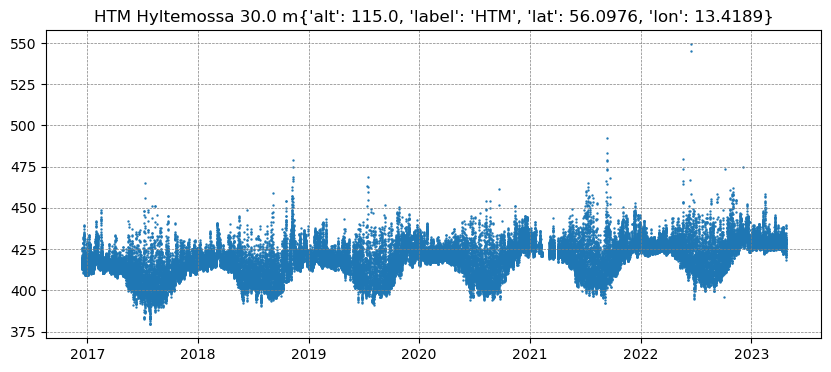

In [16]:
simplefig, ax = plt.subplots(figsize=(10,4))
ax.grid(color='grey', linestyle='--', linewidth=0.5)
ax.set_title(label(dataset)+ str(dataset.station['location'])) # see function in the begginin of the notebook
ax.scatter(data.time, data.ppm, s=0.5) # s = size of marker
simplefig.show()

### Add rolling mean

In [17]:
# add a rolling mean with approxiamtely a monthly window
rm = data.ewm(span = 720).mean()
ax.plot(rm.index, rm.ppm, color='black', linestyle='dashed')

### Add outliers from a rolling mean
As you can see, there are some outliers in the dataset. We will hightliht them with zscore (see functions in the beginning of the notebook). The function will calculate the distance in standard deviations for a rolling window. First we will add the zscore to the dataset (we could have done this in the add data features section as well). Assuming the data would follow a normal distribution, we will highlight data points which have a distance of more than 3 standard deviations (per rolling window). As a default the window size is set to approximately a monthly window.

In [18]:
# add the zscore to the data set
data['zscore'] = zscore(data.ppm)
zfilter = (data.zscore > 3) | (data.zscore < -3) 
outliers = data[zfilter]
ax.plot(outliers.index, outliers.ppm, 'ro',markersize='1')

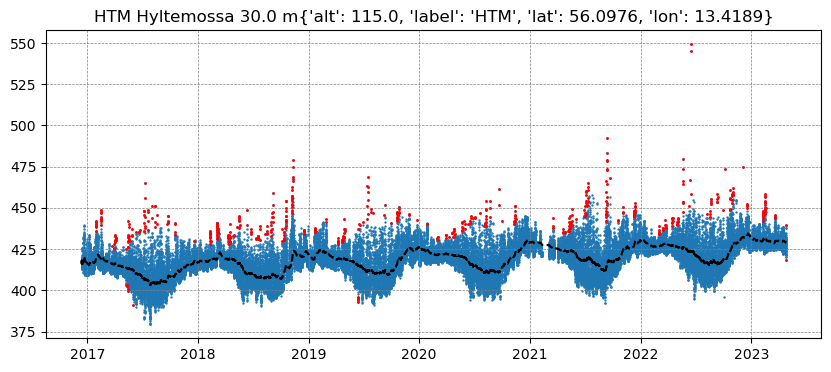

In [19]:
simplefig

### Aggregate data plot

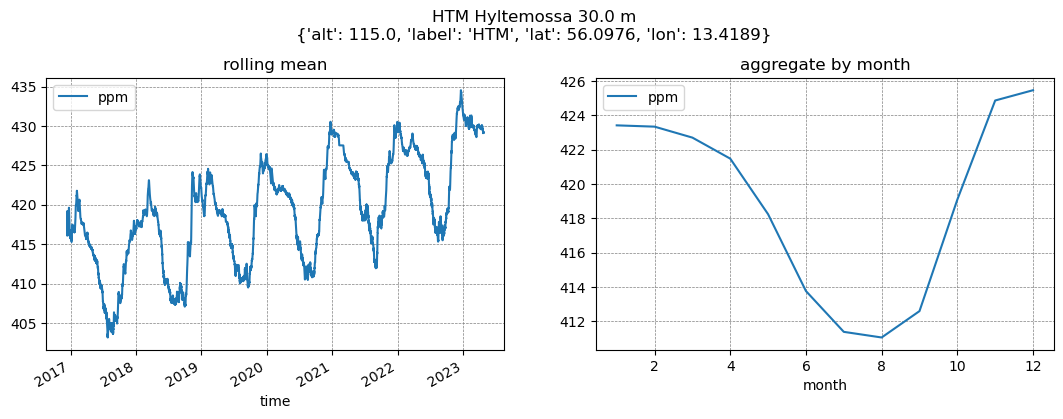

In [20]:
# create a plot with running average and aggregate by month
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
fig.suptitle(label(dataset)+'\n'+ str(dataset.station['location']), fontsize=12, y=1.05)

# a rolling mean with a monthly window, makes a trend clearly visible
data.ewm(span = 720).mean().plot(y='ppm', grid=True, ax=ax1)
ax1.set_title('rolling mean')
ax1.grid(color='grey', linestyle='--', linewidth=0.5)

# aggregate by month, to show seasonality
data.groupby(['month'], sort=False, group_keys=False ).mean().sort_index().plot(y='ppm',grid=True, ax=ax2)
ax2.set_title('aggregate by month')
ax2.grid(color='grey', linestyle='--', linewidth=0.5)

fig.show()

### Boxplot

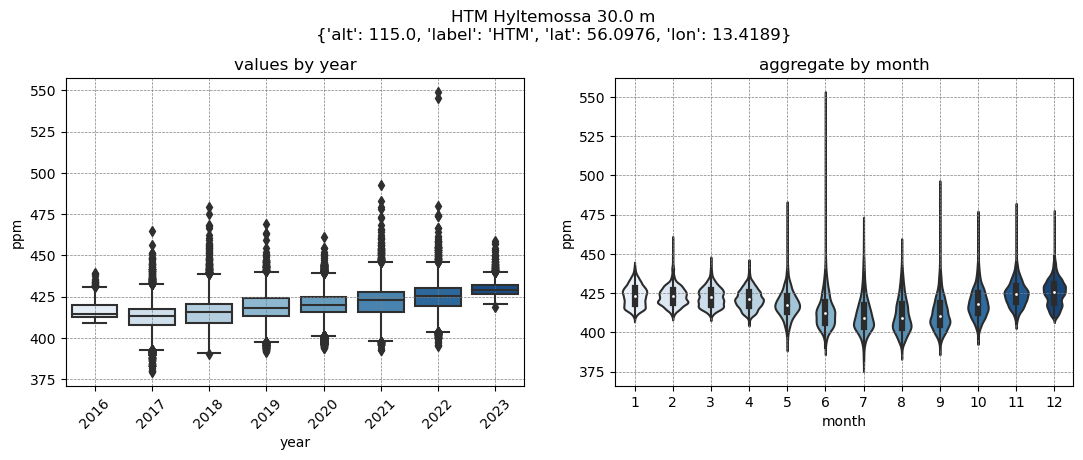

In [22]:
# create a more fancy plot with seaborn

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
fig.suptitle(label(dataset)+'\n'+ str(dataset.station['location']), fontsize=12, y=1.05)
sns.boxplot(data=data, x='year', y='ppm', palette='Blues', ax=ax1)
ax1.set_title('values by year')
ax1.grid(color='grey', linestyle='--', linewidth=0.5)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)

sns.violinplot(data=data, x='month', y='ppm', palette='Blues', ax=ax2)
ax2.set_title('aggregate by month')
ax2.grid(color='grey', linestyle='--', linewidth=0.5)

fig.show()

### Loop through the collection

Since we now have a better understanding of the underlying data, we can plot many datasets side by side to compare.<br>
We demonstrate a simple filter implententation for country and/or station id. If you want to have all (countries or stations) set the filter to an empty list.<br>
The following example finds all stations from **Switzerland** plus adding the **'Schauinsland'** station from Germany and **'Weybourne'** from Great Britain.

  0%|          | 0/132 [00:00<?, ?it/s]

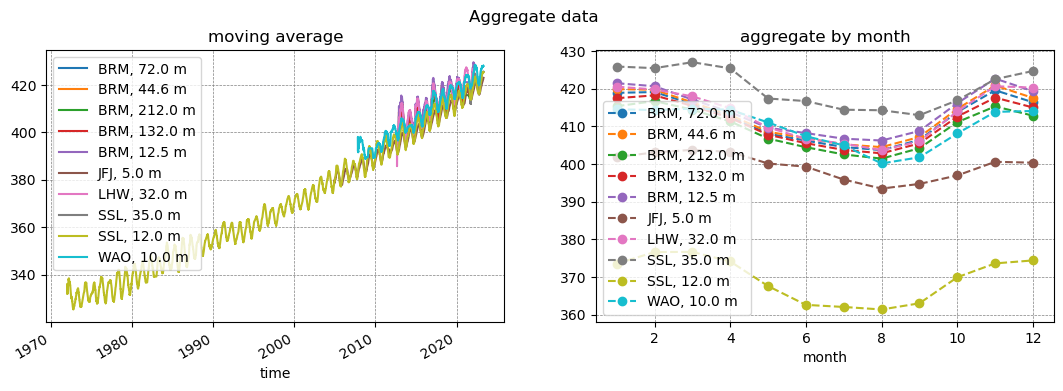

In [25]:
# filter by country, you can add multiple countries as filter
# if you want to plot ALL countries, you can use country=['ALL']
# you will find the country code for each digital object with do.station['countryCode']
country = ['CH']

# filter by station id, you can add multiple stations as filter
# you will find the station id with do.station['id']
stationid = ['SSL', 'WAO']

# create a plot with running average and aggregate by month
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
fig.suptitle('Aggregate data', fontsize=12)

ax1.set_title('moving average')
ax1.grid(color='grey', linestyle='--', linewidth=0.5)


ax2.set_title('aggregate by month')
ax2.grid(color='grey', linestyle='--', linewidth=0.5)


for do in tqdm(coll.data):
    # filter by station and country
    if 'ALL' in country:
        pass
    elif (do.station['countryCode'] not in country) and (do.station['id'] not in stationid):
        continue 
        
    # extract the data frame and add some features
    df = data_feature(do)
    
    # plot
    serieslabel = f"{do.station['id']}, {str(sampling_height(do))} m"
    df.ewm(span = 3600).mean().plot(y='ppm', grid=True, ax=ax1, label=serieslabel)
    df = df.groupby(['month'], sort=False, group_keys=False ).mean().sort_index()
    df.plot(y='ppm',grid=True, ax=ax2, label=serieslabel, marker='o', linestyle='dashed')    
    
plt.show()
    

### BoxPlot many stations

  0%|          | 0/132 [00:00<?, ?it/s]

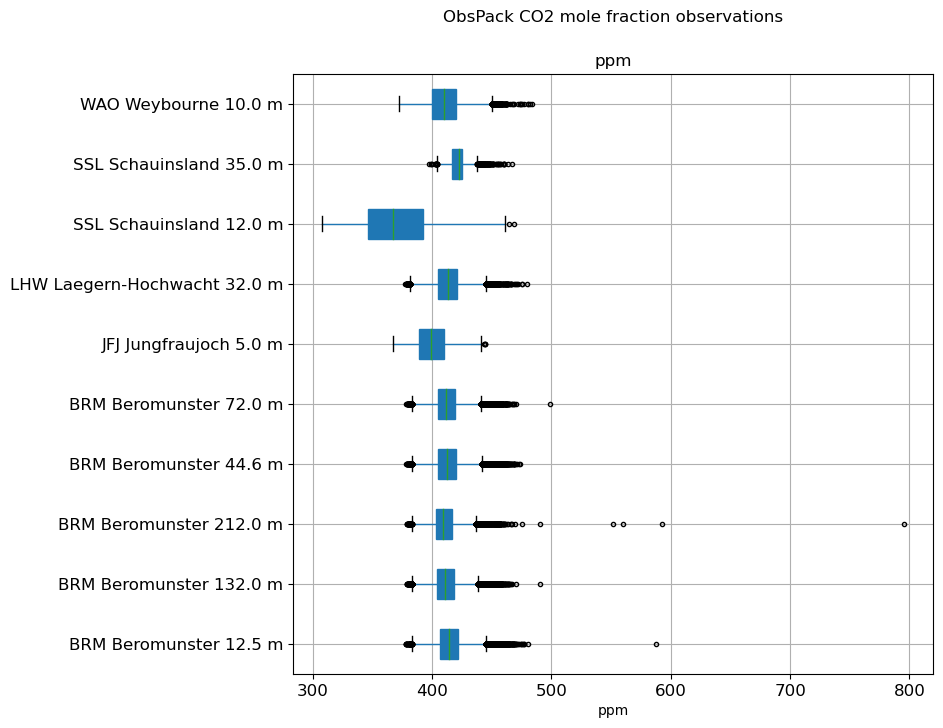

In [24]:
# filter by country, you can add multiple countries as filter
# if you want to plot ALL countries, you can use country=['ALL']
# you will find the country code for each digital object with do.station['countryCode']
country = ['CH']

# filter by station id, you can add multiple stations as filter
# you will find the station id with do.station['id']
stationid = ['SSL', 'WAO']

# depending on how many stations you want to display, 
# you probably want to adjust the figure and font size
# for all 132 stations you can try the following values
# figuresize = [10,24] 
# fontsize = 9

figuresize = [8,8] 
fontsize = 12

# Initialize the figure
f, ax = plt.subplots(figsize=figuresize)
frames= []

#------------------------------------

for do in tqdm(coll.data):
    # filter by station and country
    if 'ALL' in country:
        pass
    elif (do.station['countryCode'] not in country) and (do.station['id'] not in stationid):
        continue 
    
    # add features, like day, month, ppm for ease of use
    df = data_feature(do)
    
    # add some feature from the metatdata of the object
    df['label'] = label(do)
    frames.append(df)

if(frames):
    result = pd.concat(frames)
    result.boxplot('ppm',by='label',vert=False, ax=ax, fontsize=fontsize,flierprops={'marker': '.'},patch_artist = True)

    f.suptitle('ObsPack CO2 mole fraction observations')
    ax.set_xlabel('ppm')
    plt.show()
else:
    print('no results')
    f.clear()
    ax.clear